In [3]:
library(dplyr)
library(readr)
library(ggplot2)
library(digest)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [4]:
url_1<- "https://docs.google.com/spreadsheets/d/e/2PACX-1vRvUUk-oL0Q6CIY8g121I7U4hqTg5jS7WNftta2fCnIUXkw7V1ARx0soXD613ShCrkFqDwRk3wCE8d7/pub?gid=0&single=true&output=csv"
download.file(url_1, destfile="104鼻咽癌資料")
cancer_data <- read_csv("104鼻咽癌資料")

Parsed with column specification:
cols(
  .default = col_double(),
  `姓名(3)` = col_character(),
  `死亡原因碼(32)` = col_character(),
  `腫瘤部位(47)` = col_character(),
  `其他(54)` = col_character(),
  `臨床T(92)` = col_character(),
  `臨床N(93)` = col_character(),
  `臨床期別組合(95)` = col_character()
)
See spec(...) for full column specifications.


In [5]:
dat <- select(cancer_data,'性別(5)',`診斷年齡(33)`)
names(dat) <- c("sex","age")


# 呈現性別、年齡資料分布型態

In [6]:
sex_dat <- data.frame( sex = c("male","female"),
                       quantity = c(nrow(dat[dat$sex==1,1]),nrow(dat[dat$sex==2,1])))
head(sex_dat)

sex,quantity
male,60
female,33


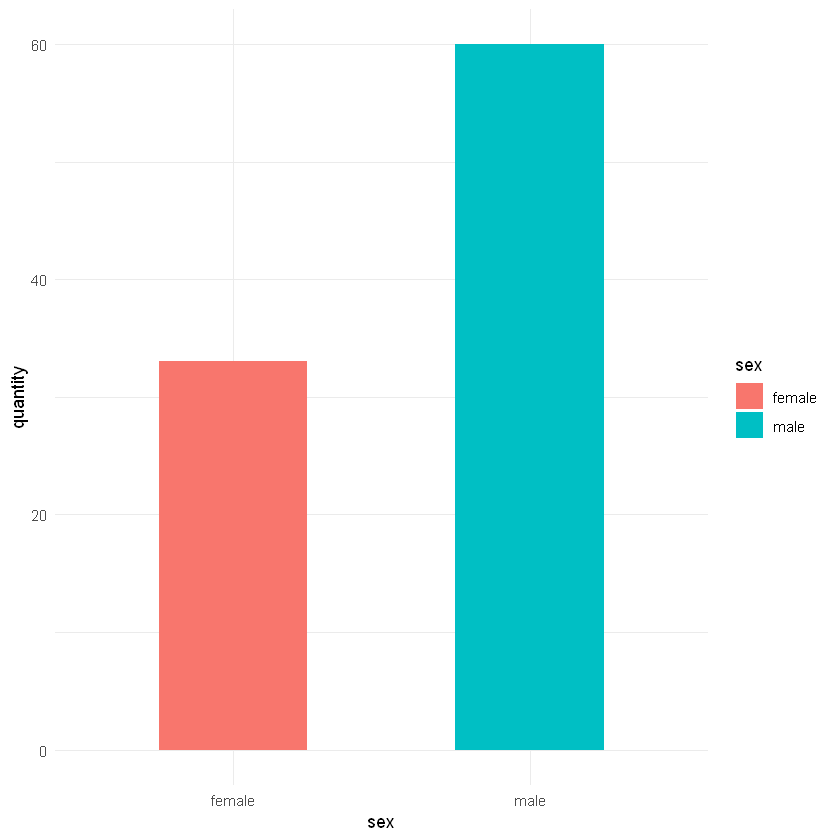

In [7]:
sex_plot <- ggplot(data = sex_dat, aes(x = sex,y = quantity, fill = sex) ) +
            geom_bar(stat="identity", width=0.5)+theme_minimal()
print(sex_plot)

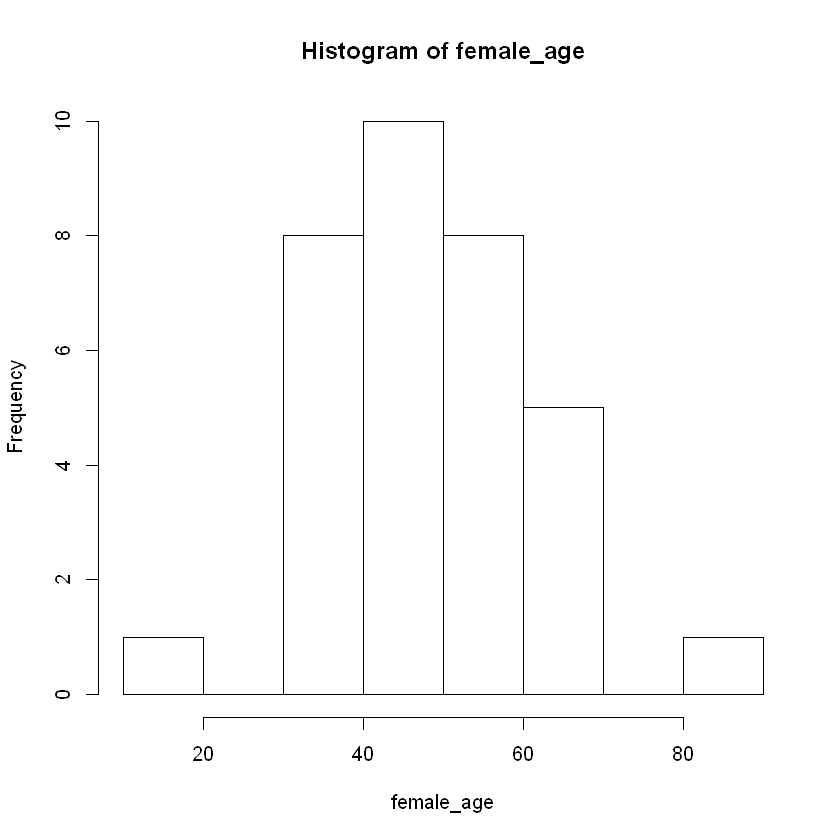

In [8]:
female_age <- filter(dat,sex==2) %>% select(age) 
female_age <- as.numeric(unlist(female_age))
male_age <- filter(dat,sex==1) %>% select(age)
male_age <- as.numeric(unlist(male_age))
female_age <- hist(female_age)

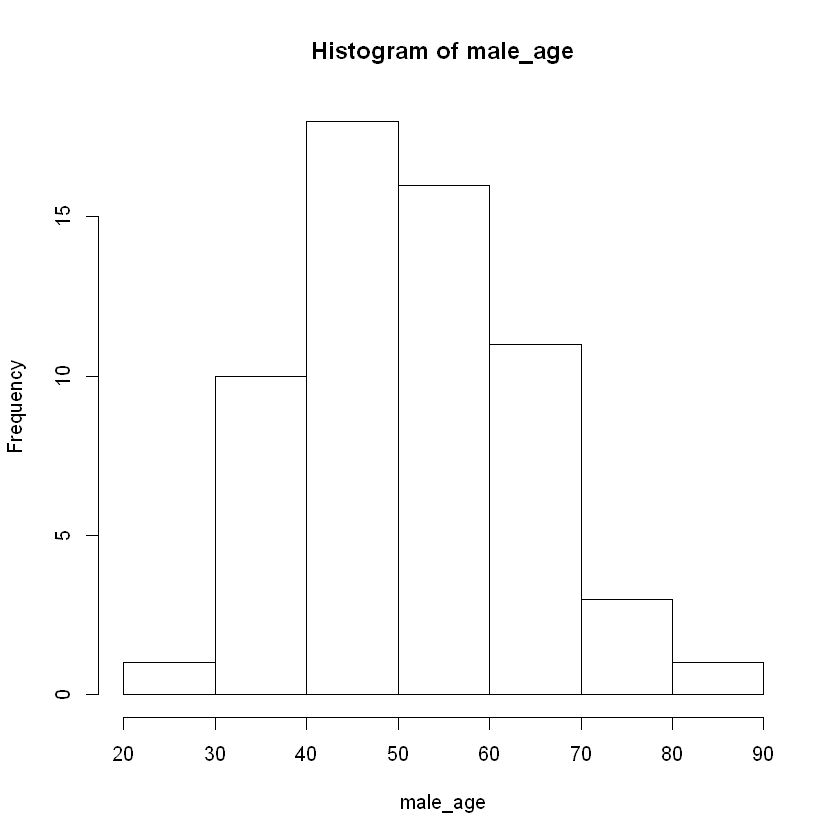

In [9]:
male_age <- hist(male_age)

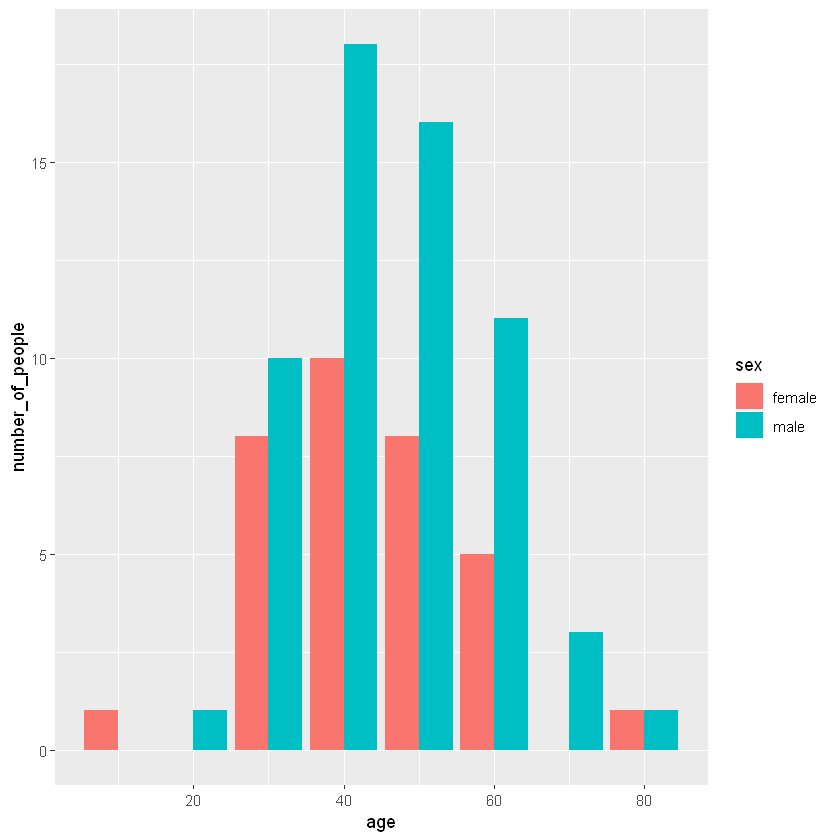

In [10]:
len <- c(0,male_age$counts,female_age$counts)
age_dat <- data.frame( sex = rep(c("male","female"), each=8),
                       age = rep(seq(10,80,10),2),
                       number_of_people = len)
ggplot(data=age_dat, aes(x=age, y=number_of_people, fill=sex)) +
  geom_bar(stat="identity", position=position_dodge())

In [11]:
head(sex_dat)

sex,quantity
male,60
female,33


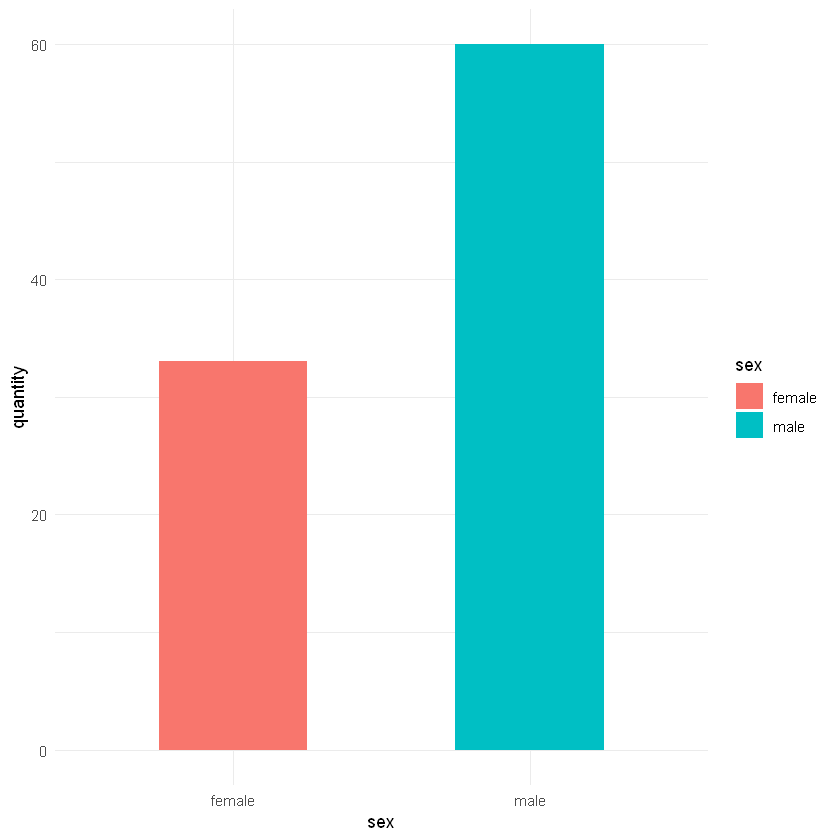

In [12]:
age_plot <- ggplot(data = sex_dat, aes(x = age,y = quantity, fill = sex) ) +
  geom_bar(stat="identity", width=0.5)+theme_minimal()
print(sex_plot)

In [13]:
severity <- select(cancer_data,'腫瘤大小(86)',`分化程度(50)`)
# preview tumor size classification
size_class <- unique(severity[,1])
size_class[size_class > 989] <- 0 #去除>989之值，找最大值做腫瘤大小的分數規則 
max_size <- max(size_class) 
size_grade <- round( max_size / 10 )#將腫瘤大小分為十級，每增加多少ｍｍ之腫瘤，腫瘤大小上升一級
severity[severity[,1] > 989,1] <- NA # 腫瘤大小情形沒有介於989~999之間的值，因此>989即為腫瘤大小不詳，計為ＮＡ
severity[,1] <- sapply(severity[,1], function(x){
  y = round( x/size_grade );
  return(y)
}) 

# preview tumor diffrentiation classification
分化程度有４，２，３，９四種情形腫瘤分化程度越低，惡化程度越嚴重

In [14]:
unique(severity[,2])

分化程度(50)
4
2
3
9


In [15]:
severity[severity[,2] == 4 ,2] <- 0 # 分化程度為４為未分化，計為０，９為不詳，計為ＮＡ
severity[severity[,2] == 9 ,2] <- NA
# 評量分數計算為腫瘤大小加上分化程度，若其中一項未知，則只採用其中一項，若兩者皆未知既為ＮＡ
severity <- mutate(severity,severity_result= mapply(function(x,y){
  z = ifelse(is.na(x) & is.na(y),NA,ifelse(is.na(x)|is.na(y),ifelse(is.na(x),y,x),x+y))
  return(z)
},severity[,1],severity[,2]))

# 將病患生活習慣量化以做評估
抽菸＝每日抽菸量*抽菸年計算

In [16]:
smoking <- select(cancer_data,'每日吸菸量(A3-1)',`吸菸年(A3-2)`)
not_sure_q <- which( smoking[,1]==91|smoking[,1]==98 ) # 若吸菸年量不確定為９１及９８，先計為０，之後以平均值計算
not_sure_y <- which( smoking[,2]==91|smoking[,2]==98 )
smoking[smoking[,1]>90,1] <- NA # 若吸菸量不詳，為９９，計為ＮＡ
smoking[smoking[,2]>90,2] <- NA # 若吸菸年不詳，為９９，計為ＮＡ

若吸菸年或吸菸數量／年為不一定，以平均吸菸量/年計算

In [17]:
smo_q_ave <- sum(smoking[,1],na.rm = T) / length(is.na(smoking[,1]))
smoking[not_sure_q,1] <- round(smo_q_ave) 
smo_y_ave <- sum(smoking[,2],na.rm = T) / length(is.na(smoking[,2]))
smoking[not_sure_y,2] <- round(smo_y_ave)

評量分數計算為每日抽菸量*抽菸年，若其中一項未知，則只採用其中一項，若皆未知既為ＮＡ

In [18]:
smoking <- mutate(smoking,smoke_result= mapply(function(x,y){
  z = ifelse(is.na(x) & is.na(y),NA,ifelse(is.na(x)|is.na(y),ifelse(is.na(x),y,x),x*y))
  return(z)
},smoking[,1],smoking[,2]))

# 將病患生活習慣量化以做評估
嚼檳榔＝每日嚼檳榔量*嚼檳榔年計算

In [19]:
areca <- select(cancer_data,'每日嚼檳榔量(A4-1)',`嚼檳榔年(A4-2)`)
not_sure_q <- which( areca[,1]==91|areca[,1]==98 ) # 若嚼檳榔年量不確定為９１及９８，先計為０，之後以平均值計算
not_sure_y <- which( areca[,2]==91|areca[,2]==98 )
areca[areca[,1]>90,1] <- NA # 若吸菸量不詳，為９９，計為ＮＡ
areca[areca[,2]>90,2] <- NA # 若吸菸年不詳，為９９，計為ＮＡ

若嚼檳榔年或嚼檳榔數量／年為不一定，以平均吸菸量/年計算

In [20]:
areca_q_ave <- sum(areca[,1],na.rm = T) / length(is.na(areca[,1]))
areca[not_sure_q,1] <- round(areca_q_ave) 
areca_y_ave <- sum(areca[,2],na.rm = T) / length(is.na(areca[,2]))
areca[not_sure_y,2] <- round(areca_y_ave)

# 評量分數計算為每日嚼檳榔量*嚼檳榔年，若其中一項未知，則只採用其中一項，若皆未知既為ＮＡ
areca <- mutate(areca,areca_result= mapply(function(x,y){
  z = ifelse(is.na(x) & is.na(y),NA,ifelse(is.na(x)|is.na(y),ifelse(is.na(x),y,x),x*y))
  return(z)
},areca[,1],areca[,2]))

# 將病患生活習慣量化以做評估
喝酒行為則以分類計算:從未喝酒、已戒、偶爾喝(不論年數)、習慣性喝酒＜10 年、習慣性喝酒≧10 年、不明

In [21]:
alcohol <- select(cancer_data,'喝酒行為(A5)')
alcohol[alcohol[,1]==999,1] <- NA # 若喝酒行為不詳，為999，計為ＮＡ

# 計算病患BMI以做評估分類
BMI = 體重(公斤)/身高(公尺)^2 正常BMI值介於18.5~24，若不正常設為1，正常為0

In [22]:
BMI <- select(cancer_data,'體重(A2)','身高(A1)')
BMI[BMI[,1]==999,1] <- NA # 若體重不詳，為999，計為ＮＡ
BMI[BMI[,2]==999,2] <- NA # 若身高不詳，為999，計為ＮＡ
BMI <- mutate(BMI,BMI_result= mapply(function(x,y){
  z = ifelse(is.na(x) & is.na(y),NA,ifelse(is.na(x)|is.na(y),ifelse(is.na(x),NA,NA),x/(0.01*y)^2) )
  z = round(z)
  z = ifelse(z>=18.5&z<24,0,1)
  return(z)
},BMI[,1],BMI[,2]))

In [24]:
BMI

體重(A2),身高(A1),BMI_result
81,171,1
66,158,1
NA,NA,NA
51,167,1
74,172,1
62,147,1
NA,NA,NA
NA,NA,NA
52,163,0
NA,NA,NA
